In [10]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
%matplotlib inline

In [11]:
# Load camera calibration parameters in the saved objpoints and imgpoints
calibration_pickle = pickle.load(open('./20-output-cameraCalibration.p', 'rb' ))
mtx = calibration_pickle["mtx"]
dist = calibration_pickle["dist"]

In [32]:
def pltSingle(img, title, plot=True, axis_grid='off'):
    if plot == True:
        f, ax = plt.subplots(1,1)
        ax.imshow(img)
        ax.set_title(title)
        ax.axis(axis_grid)
        plt.show()

In [33]:
def pltCompare(img1, title1, img2, title2, plot=True, axis_grid='off'):
    if plot == True:
        f, (ax1, ax2) = plt.subplots(1,2)
        ax1.imshow(img1)
        ax1.set_title(title1)
        ax1.axis(axis_grid)
        ax2.imshow(img2)
        ax2.set_title(title2)
        ax2.axis(axis_grid)
        plt.show()

Sobel operator allows to calculate the image derivative in X or Y axis. As presented previously, several measurements can be derived from those gradients. Combining those measurements with they respective threshold can easy the lane line detection.

The pipeline below apply those different measurements and thresholds.

## Parameters

In [14]:
PAR_COLOR2GRAY = cv2.COLOR_RGB2GRAY

In [15]:
# Define a function that applies Sobel x and y, 
# then computes the magnitude of the gradient
# and applies a threshold
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, PAR_COLOR2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    x = 1 if orient == 'x' else 0
    y = 1 if orient == 'y' else 0
    sobel = cv2.Sobel(gray, cv2.CV_64F, x, y)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel > thresh[0]) & (scaled_sobel < thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

In [16]:
# Computes the magnitude of the gradient and applies a threshold
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, PAR_COLOR2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Calculate the magnitude 
    magnitude = np.sqrt(sobelx**2 + sobely**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scale_magnitude = np.uint8(255 * magnitude / np.max(magnitude))
    # 5) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(scale_magnitude)
    binary_output[(scale_magnitude > mag_thresh[0]) & (scale_magnitude < mag_thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

In [17]:
# Computes the direction of the gradient and applies a threshold.
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, PAR_COLOR2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    dir_gradient = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(dir_gradient)
    binary_output[(dir_gradient >= thresh[0]) & (dir_gradient <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

In [41]:
def color_threshold(image, sthresh=(0,255), vthresh=(0,255)):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= sthresh[0]) & (s_channel <= sthresh[1])] = 1
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    v_channel = hsv[:,:,2]
    v_binary = np.zeros_like(v_channel)
    v_binary[(v_channel >= vthresh[0]) & (v_channel <= vthresh[1])] = 1
    output = np.zeros_like(s_channel)
    output[(s_binary == 1) & (v_binary == 1)] = 1
    return output

In [46]:
def ppBirdEye(img, plot=False):
    pltSingle(img, 'Original image', plot)
    
    img = cv2.undistort(img, mtx, dist, None, mtx)
    pltSingle(img, 'Output: Undistorted image', plot)


    # Sobel kernel size
    ksize = 21 # Choose a larger odd number to smooth gradient measurements

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=(50, 200))
    grady = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh=(50, 200))
    mag_binary = mag_thresh(img, sobel_kernel=ksize, mag_thresh=(50, 200))
    dir_binary = dir_threshold(img, sobel_kernel=ksize, thresh=(0.7, 1.3))
    c_binary = color_threshold(img, sthresh=(100,255), vthresh=(200,255))
    combined = np.zeros_like(dir_binary)
    #combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    combined[((gradx == 1) & (grady == 1) | (c_binary == 1))] = 255

    
    # process image and generate binary pixel of interests
    '''binary_image = np.zeros_like(img[:,:,0])
    gradx = abs_sobel_thresh(img, orient='x', thresh=(25,255)) # 12
    grady = abs_sobel_thresh(img, orient='y', thresh=(10,255)) # 25
    c_binary = color_threshold(img, sthresh=(100,255), vthresh=(200,255)) 
    preprocessImage[((gradx == 1) & (grady == 1) | (c_binary == 1) )] = 255
    '''

    # Perspective transformation area
    img_size = img.shape[1::-1]
    bot_width = .76 # percent of bottom trapizoid height
    mid_width = .16 # percent of middle trapizoid height
    height_pct = .66 # percent for trapizoid height
    bottom_trim = .935 # percent from top to bottom to avoid car hood 
    src = np.float32([[img.shape[1]*(.5-mid_width/2),img.shape[0]*height_pct],
                      [img.shape[1]*(.5+mid_width/2),img.shape[0]*height_pct],
                      [img.shape[1]*(.5+bot_width/2),img.shape[0]*bottom_trim],
                      [img.shape[1]*(.5-bot_width/2),img.shape[0]*bottom_trim]])
    offset = img_size[0]*.33
    dst = np.float32([[offset, 0], 
                      [img_size[0]-offset, 0],
                      [img_size[0]-offset, img_size[1]],
                      [offset ,img_size[1]]])

    # Transform
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(combined, M, img_size, flags=cv2.INTER_LINEAR)

    pltSingle(warped, 'Output: Transfomed - BirdEye view', plot)
    return warped

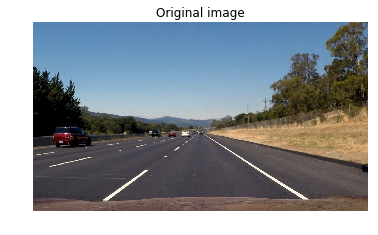

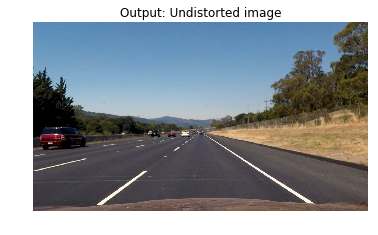

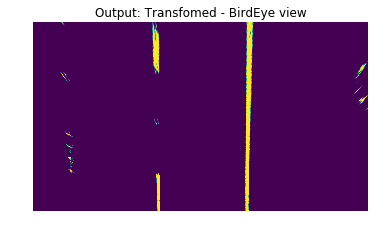

In [77]:
# Parameters
# Path for Calibration directory 
testImage_DIR = '11-input-centerCamera-testImages/'
# Filename for Calibration sample image
testImage_sample_FILE = 'straight_lines2.jpg'
img_sample = mpimg.imread(testImage_DIR + testImage_sample_FILE)
img_sample_warped = ppBirdEye(img_sample, True)

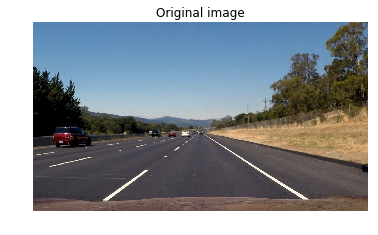

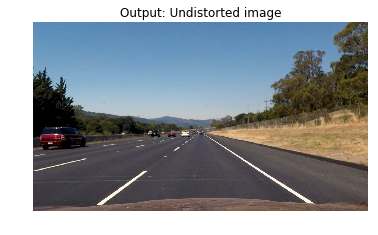

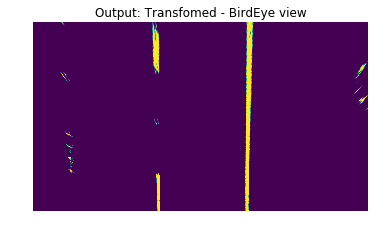

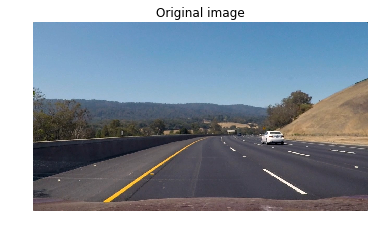

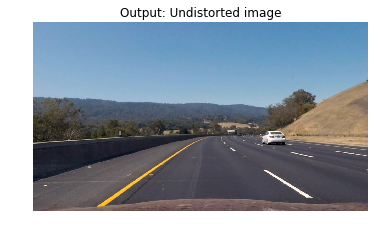

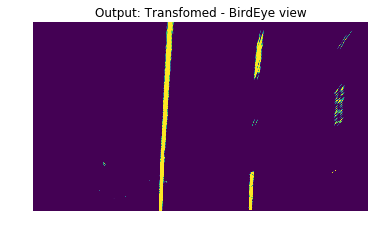

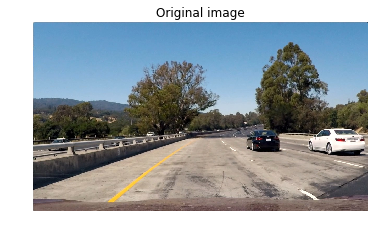

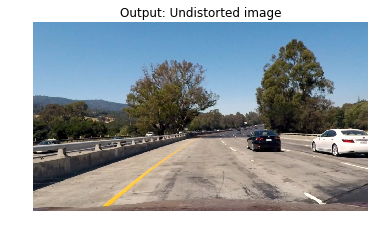

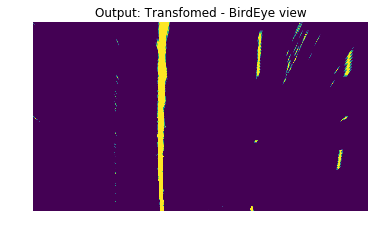

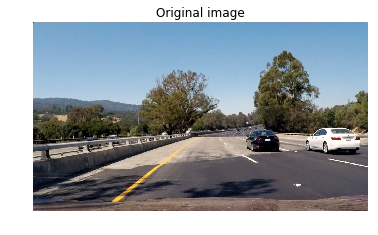

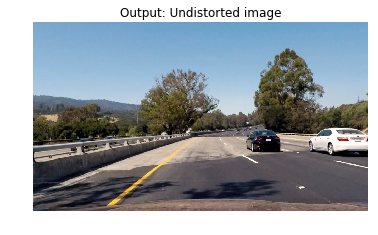

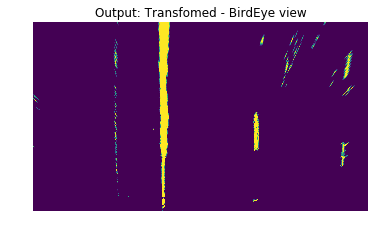

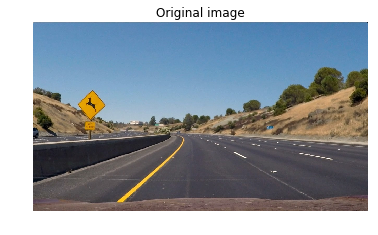

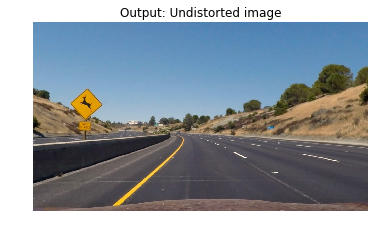

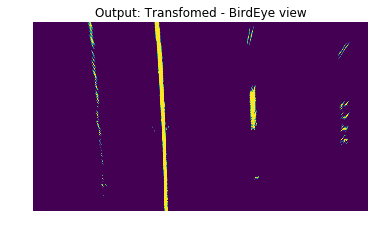

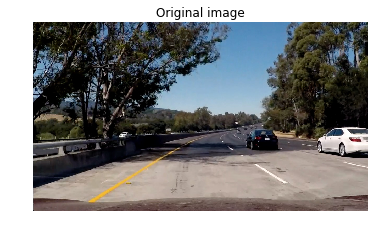

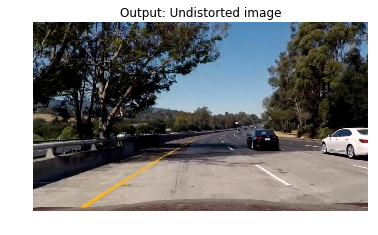

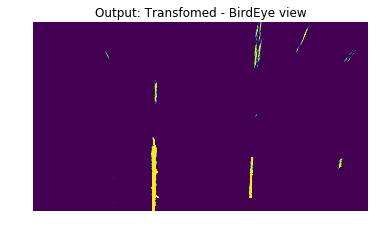

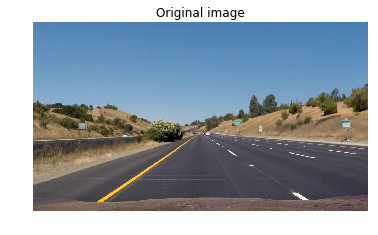

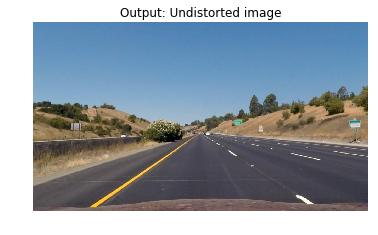

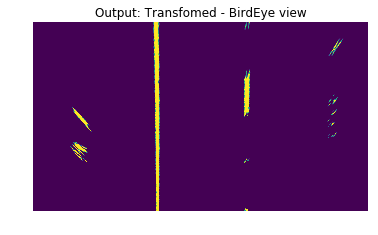

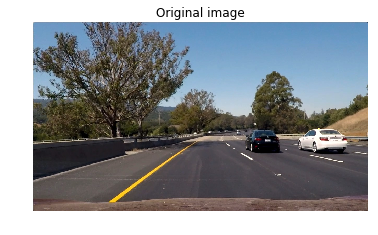

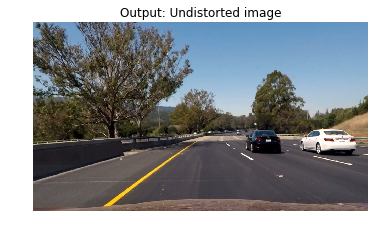

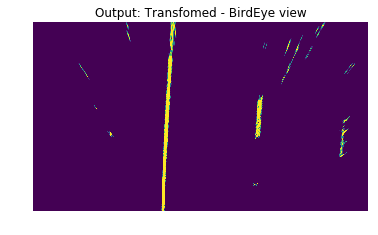

In [44]:
import glob
images = glob.glob(testImage_DIR + '*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = mpimg.imread(fname)
    _ = ppBirdEye(img, True)

In [85]:
# Read in a thresholded image
warped = img_sample_warped
# window settings
window_width = 25 
window_height = 160 # Break image into 9 vertical layers since image height is 720
margin = 25 # How much to slide left and right for searching

recent_centers = []

def find_window_centroids(image, window_width, window_height, margin, smooth_factor=1):
    global recent_centers
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(warped.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))
    
    recent_centers.append(window_centroids)
    # Average window centers
    #return np.average(recent_centers[-smooth_factor:], axis=0)
    return window_centroids

In [80]:
# Parameters
ym = 10/720
xm = 4/384 

### Helper function to draw detected windows

In [81]:
def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

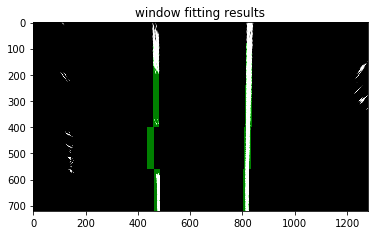

In [86]:
window_centroids = find_window_centroids(warped, window_width, window_height, margin)

# If we found any window centers
if len(window_centroids) > 0:

    # Points used to draw all the left and right windows
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)

    # Go through each level and draw the windows 	
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
        l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
        r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
        # Add graphic points from window mask here to total pixels found 
        l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
        r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    # Draw the results
    template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channel
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
    warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
    output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
 
# If no window centers found, just display orginal road image
else:
    output = np.array(cv2.merge((warped,warped,warped)),np.uint8)

# Display the final results
plt.imshow(output)
plt.title('window fitting results')
plt.show()


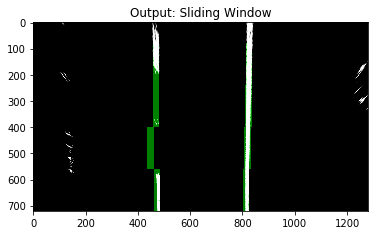

/home/hma/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:44: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/hma/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:49: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


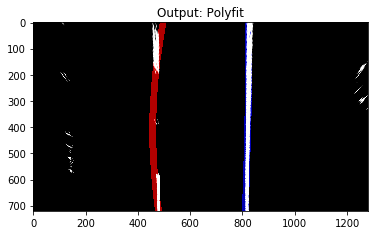

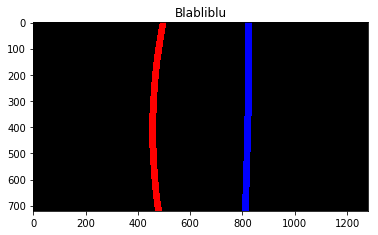

In [96]:
window_centroids = find_window_centroids(warped, window_width, window_height, margin)

# If we found any window centers
if len(window_centroids) > 0:

    # Points used to draw all the left and right windows
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)
    
    # Points used to find the left and right lanes
    leftx = []
    rightx = []

    # Go through each level and draw the windows 	
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
        l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
        r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
        # Add graphic points from window mask here to total pixels found 
        l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
        r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255
        # Add center value found in frame to the list of lane points per left,right
        leftx.append(window_centroids[level][0])
        rightx.append(window_centroids[level][1])
        
    # Draw the results
    template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channel
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
    warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
    output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
 
    plt.imshow(output)
    plt.title('Output: Sliding Window')
    plt.show()

    # fit the lane boundaries to the left,right center positions found
    yvals = range(0,warped.shape[0])
    
    res_yvals = np.arange(warped.shape[0]-(window_height/2), 0,-window_height)

    # Polyfit on 2nd degree to the boxes identified - Left lane
    left_fit = np.polyfit(res_yvals, leftx, 2)
    left_fitx = left_fit[0]*yvals*yvals + left_fit[1]*yvals + left_fit[2]    
    left_fitx = np.array(left_fitx,np.int32)

    # Polyfit on 2nd degree to the boxes identified - Right lane
    right_fit = np.polyfit(res_yvals, rightx, 2)
    right_fitx = right_fit[0]*yvals*yvals + right_fit[1]*yvals + right_fit[2]
    right_fitx = np.array(right_fitx,np.int32)

    # Format lists as input for cv2 draw functions
    left_lane = np.array(list(zip(np.concatenate((left_fitx-window_width/2,left_fitx[::-1]+window_width/2), axis=0),np.concatenate((yvals,yvals[::-1]),axis=0))),np.int32)
    right_lane = np.array(list(zip(np.concatenate((right_fitx-window_width/2,right_fitx[::-1]+window_width/2), axis=0),np.concatenate((yvals,yvals[::-1]),axis=0))),np.int32)
    
    # draw lane lines, middle curve, road background on two different blank overlays
    road = np.zeros_like(template)
    road_bkg = np.zeros_like(template)
    
    cv2.fillPoly(road,[left_lane],color=[255, 0, 0])
    cv2.fillPoly(road,[right_lane],color=[0, 0, 255])
    
    output = cv2.addWeighted(warpage, 1, road, 0.7, 0.0)
    
    plt.imshow(output)
    plt.title('Output: Polyfit')
    plt.show()
    
    
    
    road_warped = cv2.warpPerspective(road, Minv, img_size, flags=cv2.INTER_LINEAR)
    road_warped_bkg = cv2.warpPerspective(road_bkg, Minv, img_size, flags=cv2.INTER_LINEAR)
    
# If no window centers found, just display orginal road image
else:
    output = np.array(cv2.merge((warped,warped,warped)),np.uint8)

# Display the final results
plt.imshow(road)
plt.title('Blabliblu')
plt.show()
